In [101]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by Conditional Inference Trees 

CIT uses p-value as one-a-split criterion instead of using homogeneity. The algorithm will pick the feature with the least p-value and will start splitting from it. Then it will keep going until it no longer finds statistically significant p-value or some other criteria have met such as minimum node size or max split. 

In [102]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, mean_squared_error# , confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score

import matplotlib.pyplot as plt

from utils_feature_selection import r_ctree_statistics, save_selected_features


seed = np.random.seed(11)

import warnings
warnings.filterwarnings('ignore')


# ruff check ./model_preprocessing/Feature_selection/utils_feature_selection.py --fix

##### install Rpackage for ctree in python

In [103]:
# load r library initally, enables the %%R magic
# %load_ext rpy2.ipython

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats = importr("stats")

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get partykit library containing ctree , ctree_controls etc
partykit = importr('partykit')
partykit



rpy2.robjects.packages.Package as a <module 'partykit'>

### input data

In [104]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 61)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,...,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,...,5,1.0,2.0,2.0,NaN,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,...,5,NaN,3.0,2.0,NaN,NaN,3.0,NaN,736.5,1.87277


In [133]:
targets = ["Target_contentloss_euro", "Target_businessreduction"]
target = targets[0]

## TODO make entire wokflow as loop over both target variables
# ## iterate over both targets and store results 
# for target in ["Target_contentloss_euro", "Target_businessreduction"]:

#     print( f"Apply Elastic Net on {target}:\n")
#     y = df_candidates[target]


## remove cases where target information is missing
df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
print(df_candidates.shape)

X = df_candidates.drop(targets, axis=1)
y = df_candidates[target]



(350, 61)


#### Split Data

In [134]:
## test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, 
    random_state=seed, shuffle=False
)

train = pd.concat([y_train, X_train], axis=1)
test = pd.concat([y_test, X_test], axis=1)
#print(train.head(2))



### Model fit

In [135]:
###############  CV with gridSearch TODO   ###################
# ## specify model
# cit_model = partykit.ctree(Formula('Target_contentloss_euro ~ .'),  
#                                 data=train
#                           )
# ## hyperparameter tunning 
# param_dist = [{'mincriterion': 0.95}]
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# cit_model_cv = GridSearchCV(estimator = cit_model, 
#                          param_grid = param_dist
#                          )#, scoring= 'r2', cv = folds, verbose = 1,return_train_score=True)      

# # # fit the model
# cit_model_cv.fit(X_train, y_train)
  

#################### without Hyperparameter tunning  #####################
# fit ctree
## Minciterion = confidence level (smaller values => larger trees; e.g mincriterion=0.8, p-value must be smaller than 0.2 in order for a node to split)
cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
                                data=train,
                                control = partykit.ctree_control(mincriterion = 0.8)
                          )


## store trained model for evaluation
filename = f'./models_trained/cit_{target}'
pickle.dump(cit_model, open(filename, 'wb'))



## Feature selection

In [136]:
# ## actual p-values (without log)
# strucchange = importr("strucchange")
# strucchange.sctest(cit_model, node = 1)[1]  # p values

print(cit_model)


R[write to console]: Error in character_split(split_node(x), data = data, digits = digits,  : 
  unused argument (useS4 = FALSE)




Model formula:
Target_contentloss_euro ~ inundation_duration_h + water_depth_cm + 
    contaminations.0 + contaminations.1 + contaminations.2 + 
    contaminations.3 + contaminations.4 + flowvelocity + warning_time_h + 
    emergency_measures.1 + emergency_measures.2 + emergency_measures.3 + 
    emergency_measures.4 + emergency_measures.6 + emergency_measures.7 + 
    emergency_measures.8 + emergency_measures.9 + overall_problem_house + 
    protect_valuables_impl + water_barriers_impl + pumping_equipment_impl + 
    elevation_building_impl + resistant_material_building_impl + 
    electricity_higher_impl + flood_protections_impl + flood_experience + 
    elevation_building_height_cm + elevation_rel2surrounding_cat + 
    bage + b_area + hh_monthly_income_cat + shp_owner + shp_sector + 
    shp_employees + shp_avgmonthly_sale_cat + shp_finance_investments + 
    shp_suppliers_location.1 + shp_suppliers_location.2 + shp_suppliers_location.3 + 
    shp_suppliers_location.4 + shp_suppli

In [137]:
## get statisitcs to obtain important feautres

cit_stats = r_ctree_statistics(cit_model)
cit_stats.columns = X.columns
print(cit_stats)

           inundation_duration_h  water_depth_cm  contaminations.0   
statistic               2.224648        9.762376          0.152779  \
p_value                 0.999818        0.099841          1.000000   
criterion              -8.612724       -0.105184        -70.232222   

           contaminations.1  contaminations.2  contaminations.3   
statistic          0.156899          0.077979          0.036862  \
p_value            1.000000          1.000000          1.000000   
criterion        -69.486901        -89.348214       -111.050453   

           contaminations.4  flowvelocity  warning_time_h   
statistic          1.222038      3.343878        1.976657  \
p_value            1.000000      0.983763        0.999965   
criterion        -18.484021     -4.120463      -10.268805   

           emergency_measures.1  ...  resilience_left_alone   
statistic              0.476633  ...               0.277176  \
p_value                1.000000  ...               1.000000   
criterion       

In [138]:
## select based on signifcance
df_importance = cit_stats.loc[:, cit_stats.loc["p_value",:]<= 0.05]

## sort by importance
df_importance = df_importance.T
df_importance = df_importance.sort_values("statistic", ascending=False)
df_importance.head(5)
# FI importance vmtl: shp_registered_capital_euro, b_area, inundation_duration_h, water_depth_cm, resilience_govern_careing_increases 

,statistic,p_value,criterion
shp_suppliers_location.4,254.367667,1.710539e-55,-1.710539e-55
shp_registered_capital_euro,214.924063,6.831005e-47,-6.831005e-47
shp_employees,187.515152,6.540186e-41,-6.540186e-41
shp_content_value_euro,95.750679,7.687808e-21,-7.687808e-21
b_area,86.585779,7.894547e-19,-7.894547e-19


The log rather than the p-value is used because it is numerically much more stable when used for comparisons, computing the minimal value, etc. Note that the p-values can become extremely small when significant. 


statistic DEF: 

citrerion DEF: 



In [141]:
## get signifcant features
selected_feat = cit_stats.loc[:, cit_stats.loc["p_value",:]<= 0.05]

## write selected predictors to disk
save_selected_features(X_train, pd.DataFrame(y_train), selected_feat.columns, filename=f"../../input_survey_data/fs_cit_{target}.xlsx")


selected features: 10
dropped features: 49
selected features: 
['b_area', 'hh_monthly_income_cat', 'shp_sector', 'shp_employees', 'shp_avgmonthly_sale_cat', 'shp_suppliers_location.3', 'shp_suppliers_location.4', 'perception_who_responsible4protection.Rank1', 'shp_content_value_euro', 'shp_registered_capital_euro']

Saving model to disk: ../../input_survey_data/fs_cit_Target_contentloss_euro.xlsx


### Feature importance

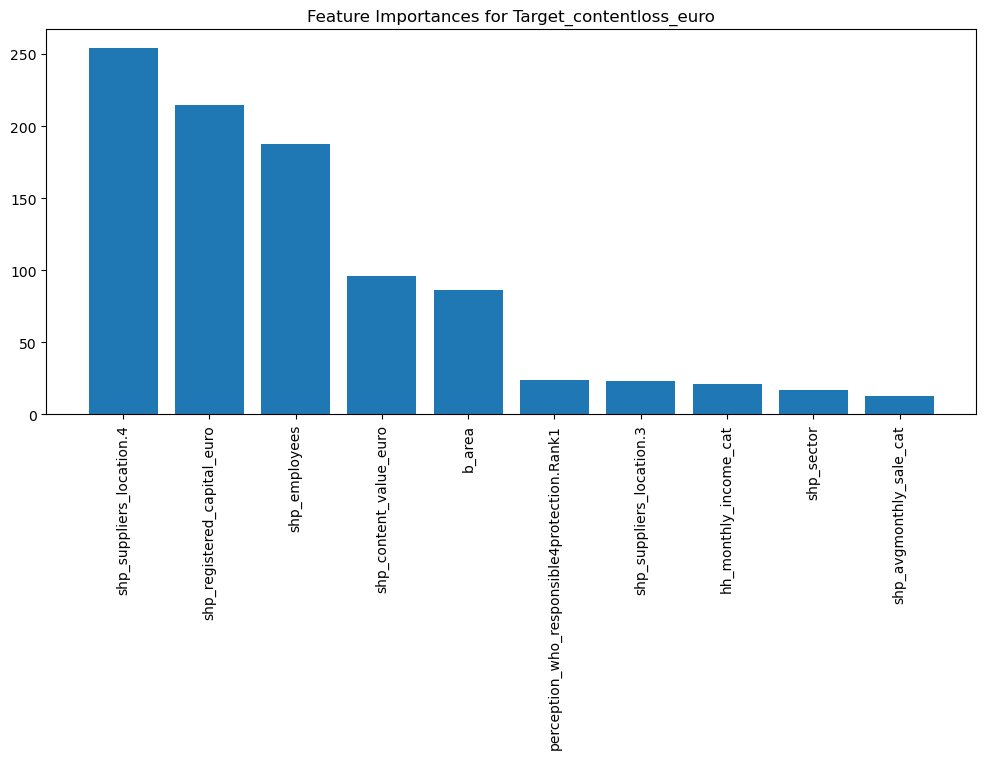

In [142]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,5))


# drop features which dont reduce the loss
# df_importance = df_importance.loc[df_importance.statistic > 3, : ]

plt.bar(df_importance.index, df_importance.statistic)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

In [113]:
y_train.shape

(289,)

In [114]:
## Predict
y_pred = stats.predict(cit_model, test, type="response") #  type = "prob" # conditional class probabilities
y_pred  = base.round(y_pred)

## get back to python dtypes
y_pred = np.array(y_pred)
y_test = np.array(y_test)
y_test = np.array(y_test)
y_test = np.array(y_test)


## TODO find good evaluation metrics eg R2 for training set 
## --> test via GridSearchCV and RepeatedKFold or RStatifiedKFold
#r2 = np.corrcoef(X_train,y_train)**2 
#print(f"Training set score (R^2): {r2}")
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print("RMSE:  {:.2f}".format(rmse)) 
#np.mean((y_test - cit_pred)**2)


## Model evaluation

In [46]:
cit_model_p = pickle.load(open(f"./models_trained/cit_{target}", 'rb'))
type(cit_model_p)
#cit_model_p.__dir__()

rpy2.robjects.vectors.ListVector

In [64]:
cit_model_p.rx(3)

R[write to console]: Error in character_split(split_node(x), data = data, digits = digits,  : 
  unused argument (useS4 = FALSE)



0,3,[1]...
1,4,...
2,5,...
3,6,Target_co...
4,7,['3' '4'...
5,8,$call (fu...


In [50]:
cit_model_p.names
cit_model_p = np.array(cit_model_p.rx(3))
cit_model_p

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [163]:
# define the model evaluation by k-fold CV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(cit_model_p, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

InvalidParameterError: The 'estimator' parameter of check_scoring must be an object implementing 'fit'. Got <rpy2.robjects.vectors.ListVector object at 0x00000282FCAEBDC0> [RTYPES.VECSXP]
R classes: ('constparty', 'party')
[Lis..., Lis..., Lis..., Lan..., NUL..., Lis..., Sex..., Sex...]
  1: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x00000282DF5FD0C0> [RTYPES.VECSXP]
  2: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x00000282DF5FA0C0> [RTYPES.VECSXP]
  3: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x00000282DF5FD0C0> [RTYPES.VECSXP]
  4: <class 'rpy2.rinterface.LangSexpVector'>
  <rpy2.rinterface.LangSexpVector object at 0x00000282DF5FA0C0> [RTYPES.LANGSXP]
  5: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x00000282DEFB6780> [RTYPES.NILSXP]
  6: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x00000282DF5FA0C0> [RTYPES.VECSXP]
  7: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x00000282DF5FD0C0> [RTYPES.CLOSXP]
  8: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x00000282F202A5C0> [RTYPES.CLOSXP] instead.

In [ ]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

(265,)